Saving address_rows.csv to address_rows (1).csv
Saving property_listings_rows.csv to property_listings_rows (1).csv


<ipython-input-1-b5ec65bd6db7>:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["price_per_sqft"] = df["price_per_sqft"].fillna(df["price_per_sqft"].median())


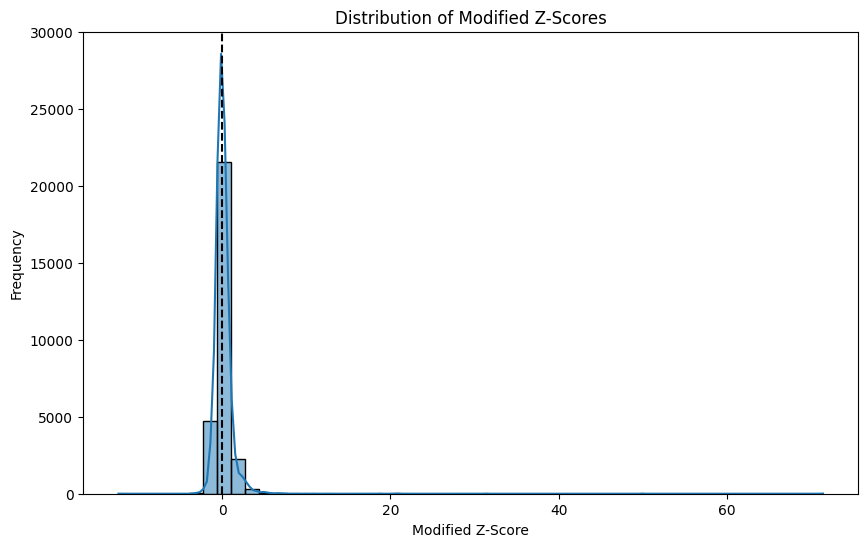

Suggested Lower Cutoff (Good Deal): -0.42895568240985216
Suggested Upper Cutoff (Bad Deal): 0.46266466151745844


,price,square_feet,postal_code,price_per_sqft,modified_z,fairness_score
0,1399000,2576.0,11694.0,543.090062,-0.432862,💎 Good Deal
1,849000,2150.0,10466.0,394.883721,-0.161561,✅ Fair Deal
2,1000000,2015.0,10304.0,496.277916,0.106948,✅ Fair Deal
3,290000,900.0,10462.0,322.222222,-0.693531,💎 Good Deal
4,599000,1860.0,10467.0,322.043011,-0.384210,✅ Fair Deal
5,1090000,2536.0,10461.0,429.810726,-0.032253,✅ Fair Deal
6,469000,1200.0,10465.0,390.833333,-0.508899,💎 Good Deal
7,1198000,2988.0,10471.0,400.937082,-1.071030,💎 Good Deal
8,695000,2128.0,10461.0,326.597744,-0.792185,💎 Good Deal
9,898000,2147.0,10461.0,418.258034,-0.117313,✅ Fair Deal


In [ ]:
# 📦 STEP 1: Upload files
from google.colab import files
uploaded = files.upload()  # Upload address.csv and property_listings.csv

# 📊 STEP 2: Load and merge data
import pandas as pd

df_address = pd.read_csv("address_rows.csv")
df_property = pd.read_csv("property_listings_rows.csv")

df = df_property.merge(df_address, left_on="address_id", right_on="id", suffixes=('_property', '_address'))

# ✏️ STEP 3: Clean and compute price per sqft
df["price_per_sqft"] = df["price"] / df["square_feet"]
df["price_per_sqft"] = df["price_per_sqft"].replace([float('inf'), -float('inf')], pd.NA)
df["price_per_sqft"] = df["price_per_sqft"].fillna(df["price_per_sqft"].median())

# 🧮 STEP 4: Compute median and MAD per ZIP
from statsmodels import robust

zip_medians = df.groupby("postal_code")["price_per_sqft"].transform("median")
zip_mads = df.groupby("postal_code")["price_per_sqft"].transform(robust.mad)

# Fallback to global stats if MAD is 0 or missing
global_median = df["price_per_sqft"].median()
global_mad = robust.mad(df["price_per_sqft"])

df["median_ppsf"] = zip_medians.fillna(global_median)
df["mad_ppsf"] = zip_mads.replace(0, global_mad).fillna(global_mad)

# 🧮 STEP 5: Calculate Modified Z-Score
df["modified_z"] = 0.6745 * (df["price_per_sqft"] - df["median_ppsf"]) / df["mad_ppsf"]

# 📊 STEP 6: Visualize Z-Score distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df["modified_z"], bins=50, kde=True)
plt.title("Distribution of Modified Z-Scores")
plt.xlabel("Modified Z-Score")
plt.ylabel("Frequency")
plt.axvline(0, color='black', linestyle='--')
plt.show()

# 📏 STEP 7: Compute empirical quantile-based thresholds
lower_cutoff = df["modified_z"].quantile(0.25)
upper_cutoff = df["modified_z"].quantile(0.75)

print("Suggested Lower Cutoff (Good Deal):", lower_cutoff)
print("Suggested Upper Cutoff (Bad Deal):", upper_cutoff)

# 🏷 STEP 8: Assign fairness labels
def new_fairness_label(z):
    if z < lower_cutoff:
        return "💎 Good Deal"
    elif z > upper_cutoff:
        return "⚠️ Bad Deal"
    else:
        return "✅ Fair Deal"

df["fairness_score"] = df["modified_z"].apply(new_fairness_label)

# ✅ DONE: Preview labeled dataset
df[["price", "square_feet", "postal_code", "price_per_sqft", "modified_z", "fairness_score"]].head(10)


Text(0.5, 1.0, 'Boxplot of Modified Z-Scores')

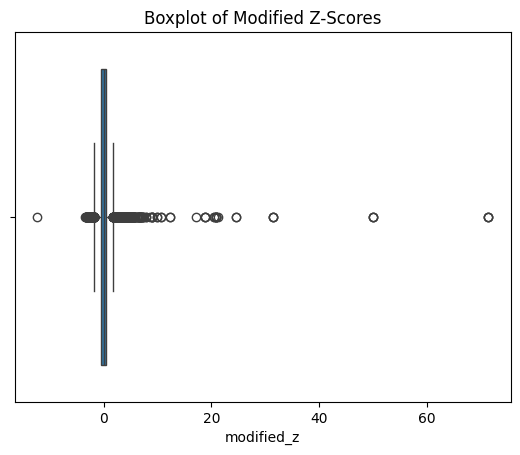

In [ ]:
sns.boxplot(x=df["modified_z"])
plt.title("Boxplot of Modified Z-Scores")


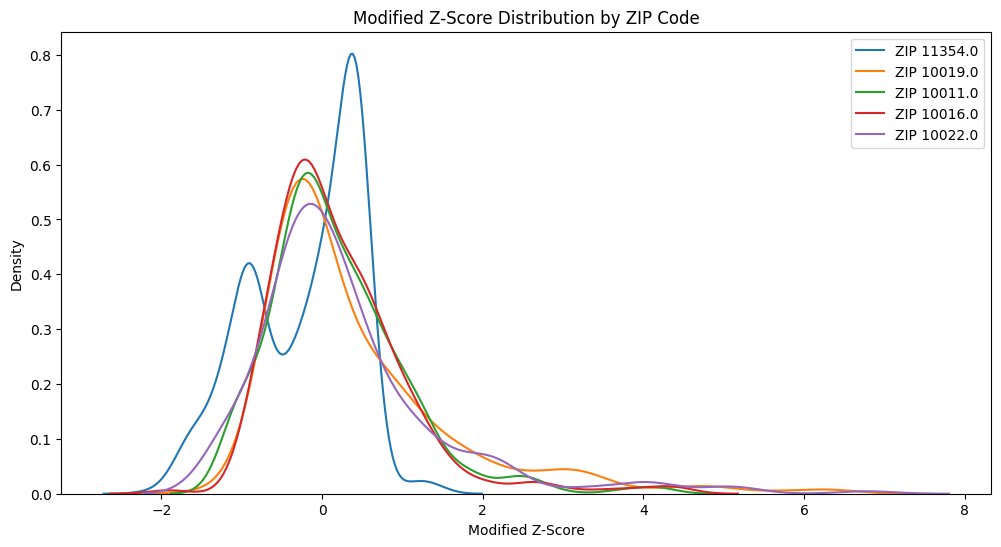

In [ ]:
top_zips = df["postal_code"].value_counts().head(5).index.tolist()

plt.figure(figsize=(12, 6))
for zip_code in top_zips:
    sns.kdeplot(df[df["postal_code"] == zip_code]["modified_z"], label=f"ZIP {zip_code}")

plt.title("Modified Z-Score Distribution by ZIP Code")
plt.xlabel("Modified Z-Score")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from statsmodels import robust

# Load CSVs
df_address = pd.read_csv("address_rows.csv")
df_property = pd.read_csv("property_listings_rows.csv")

# Merge datasets
df = df_property.merge(df_address, left_on="address_id", right_on="id", suffixes=('_property', '_address'))

# Ensure numeric types and prevent divide-by-zero
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["square_feet"] = pd.to_numeric(df["square_feet"], errors="coerce")
df = df[df["square_feet"] > 0]  # Remove listings with 0 sqft

# Calculate price per sqft
df["price_per_sqft"] = df["price"] / df["square_feet"]
df["price_per_sqft"].replace([float("inf"), -float("inf")], pd.NA, inplace=True)
df["price_per_sqft"].fillna(df["price_per_sqft"].median(), inplace=True)

# Global MAD fallback
global_mad = robust.mad(df["price_per_sqft"])

# Calculate ZIP-level thresholds and assign scores
zip_cutoffs = {}

for zip_code, group in df.groupby("postal_code"):
    median_ppsf = group["price_per_sqft"].median()
    mad_ppsf = robust.mad(group["price_per_sqft"])
    if mad_ppsf == 0 or pd.isna(mad_ppsf):
        mad_ppsf = global_mad

    modified_z = 0.6745 * (group["price_per_sqft"] - median_ppsf) / mad_ppsf
    lower = modified_z.quantile(0.20)
    upper = modified_z.quantile(0.80)
    zip_cutoffs[zip_code] = (lower, upper, median_ppsf, mad_ppsf)

def assign_fairness(row):
    zip_code = row["postal_code"]
    ppsf = row["price_per_sqft"]
    lower, upper, median, mad = zip_cutoffs.get(zip_code, (-0.4, 0.4, df["price_per_sqft"].median(), global_mad))
    if mad == 0 or pd.isna(mad):
        return "Unknown"
    z = 0.6745 * (ppsf - median) / mad
    if z < lower:
        return "💎 Good Deal"
    elif z > upper:
        return "⚠️ Bad Deal"
    else:
        return "✅ Fair Deal"

df["fairness_score"] = df.apply(assign_fairness, axis=1)

# Preview
df[["postal_code", "price_per_sqft", "fairness_score"]].head(10)

<ipython-input-4-cdfd288c7890>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["price_per_sqft"].replace([float("inf"), -float("inf")], pd.NA, inplace=True)
<ipython-input-4-cdfd288c7890>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

,postal_code,price_per_sqft,fairness_score
0,11694.0,543.090062,✅ Fair Deal
1,10466.0,394.883721,✅ Fair Deal
2,10304.0,496.277916,✅ Fair Deal
3,10462.0,322.222222,💎 Good Deal
4,10467.0,322.043011,✅ Fair Deal
5,10461.0,429.810726,✅ Fair Deal
6,10465.0,390.833333,✅ Fair Deal
7,10471.0,400.937082,💎 Good Deal
8,10461.0,326.597744,💎 Good Deal
9,10461.0,418.258034,✅ Fair Deal


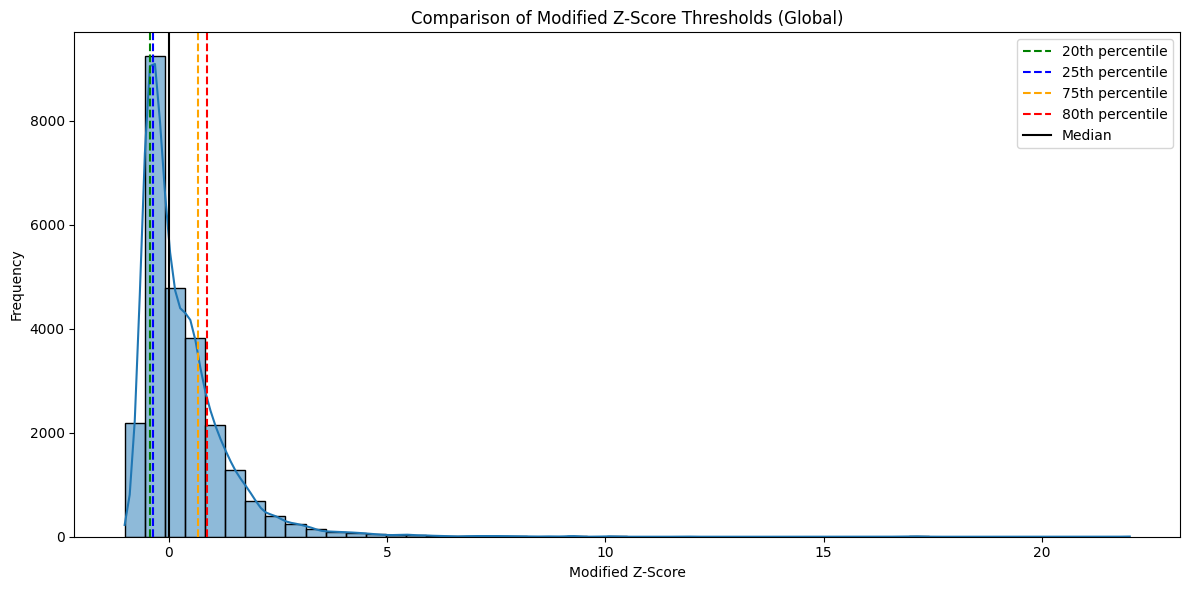

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Recompute modified_z globally to visualize its full distribution
global_median = df["price_per_sqft"].median()
global_mad = robust.mad(df["price_per_sqft"])

df["modified_z_global"] = 0.6745 * (df["price_per_sqft"] - global_median) / global_mad

# Compute various global percentiles for comparison
q20 = df["modified_z_global"].quantile(0.20)
q25 = df["modified_z_global"].quantile(0.25)
q75 = df["modified_z_global"].quantile(0.75)
q80 = df["modified_z_global"].quantile(0.80)

# Plot distribution
plt.figure(figsize=(12, 6))
sns.histplot(df["modified_z_global"], bins=50, kde=True)
plt.axvline(q20, color='green', linestyle='--', label='20th percentile')
plt.axvline(q25, color='blue', linestyle='--', label='25th percentile')
plt.axvline(q75, color='orange', linestyle='--', label='75th percentile')
plt.axvline(q80, color='red', linestyle='--', label='80th percentile')
plt.axvline(0, color='black', linestyle='-', label='Median')
plt.title("Comparison of Modified Z-Score Thresholds (Global)")
plt.xlabel("Modified Z-Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
grouped = df.groupby("postal_code")

In [ ]:
from statsmodels import robust

# Global MAD fallback for any ZIP with zero MAD
global_mad = robust.mad(df["price_per_sqft"])

# Calculate ZIP-level medians and MADs
df["median_ppsf"] = df.groupby("postal_code")["price_per_sqft"].transform("median")
df["mad_ppsf"] = df.groupby("postal_code")["price_per_sqft"].transform(
    lambda x: robust.mad(x) if robust.mad(x) != 0 else global_mad
)

# Calculate modified z-score per listing
df["modified_z"] = 0.6745 * (df["price_per_sqft"] - df["median_ppsf"]) / df["mad_ppsf"]


In [ ]:
zip_cutoffs = {}

for zip_code, group in df.groupby("postal_code"):
    if len(group) < 20:
        continue
    lower = group["modified_z"].quantile(0.25)
    upper = group["modified_z"].quantile(0.75)
    median_ppsf = group["price_per_sqft"].median()
    mad_ppsf = robust.mad(group["price_per_sqft"])

    zip_cutoffs[zip_code] = (lower, upper, median_ppsf, mad_ppsf)


In [ ]:
def label_by_zip(row):
    zip_code = row["postal_code"]
    z = row["modified_z"]

    # Get 4-tuple but only use first two values
    cutoffs = zip_cutoffs.get(zip_code, (-0.4, 0.4, 0, 1))  # fallback also gives 4 elements
    lower, upper = cutoffs[0], cutoffs[1]

    if z < lower:
        return "💎 Good Deal"
    elif z > upper:
        return "⚠️ Bad Deal"
    else:
        return "✅ Fair Deal"


In [ ]:
cutoff_df = pd.DataFrame.from_dict(
    zip_cutoffs,
    orient='index',
    columns=['Lower Cutoff', 'Upper Cutoff', 'Median PPSF', 'MAD PPSF']
)
cutoff_df.index.name = 'ZIP Code'
cutoff_df = cutoff_df.reset_index()
cutoff_df.sort_values(by='ZIP Code', inplace=True)
cutoff_df.head(10)


,ZIP Code,Lower Cutoff,Upper Cutoff,Median PPSF,MAD PPSF
0,10001.0,-0.388142,0.549226,1949.541284,608.310304
1,10002.0,-0.516991,0.436712,1911.057692,471.058839
2,10003.0,-0.414533,0.493859,1869.863014,456.702104
3,10004.0,-0.443906,0.458833,1285.653195,308.815180
4,10005.0,-0.465454,0.333574,1239.669421,367.101100
5,10006.0,-0.404299,0.623389,1553.689262,362.646407
6,10007.0,-0.454943,0.449119,2112.903226,626.317781
7,10009.0,-0.257307,0.562428,1435.132032,413.873868
8,10010.0,-0.441837,0.554980,1894.918174,518.064994
9,10011.0,-0.385410,0.622547,2112.200300,719.499765


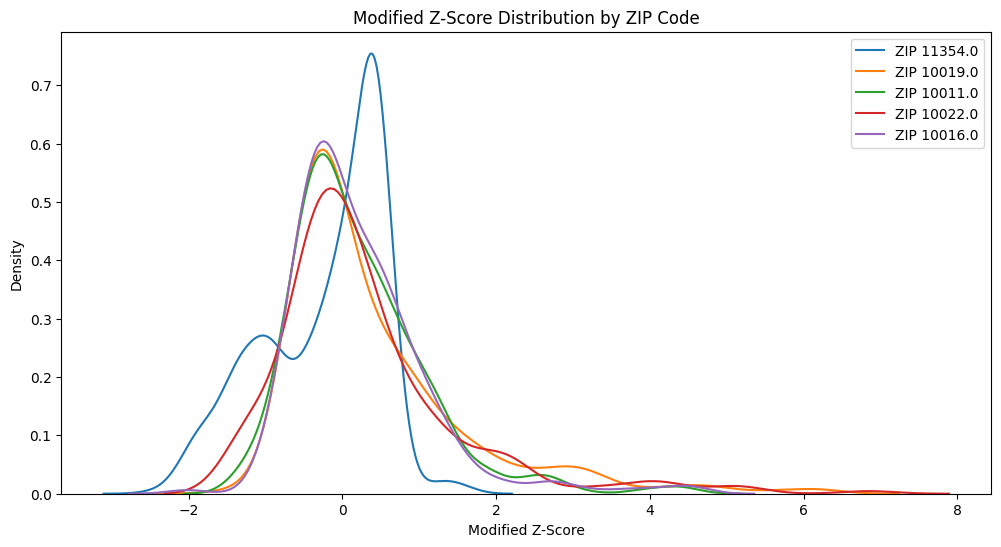

In [ ]:
top_zips = df["postal_code"].value_counts().head(5).index.tolist()

plt.figure(figsize=(12, 6))
for zip_code in top_zips:
    sns.kdeplot(df[df["postal_code"] == zip_code]["modified_z"], label=f"ZIP {zip_code}")

plt.title("Modified Z-Score Distribution by ZIP Code")
plt.xlabel("Modified Z-Score")
plt.legend()
plt.show()

In [ ]:
# Count how many listings fall into each fairness category
label_counts = df["fairness_score"].value_counts()
label_percentages = df["fairness_score"].value_counts(normalize=True) * 100

print("Label Counts:\n", label_counts)
print("\nLabel Percentages:\n", label_percentages.round(2))


Label Counts:
 fairness_score
✅ Fair Deal    12775
⚠️ Bad Deal     6262
💎 Good Deal     6251
Name: count, dtype: int64

Label Percentages:
 fairness_score
✅ Fair Deal    50.52
⚠️ Bad Deal    24.76
💎 Good Deal    24.72
Name: proportion, dtype: float64


<ipython-input-28-9e885ade41e5>:13: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-28-9e885ade41e5>:13: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


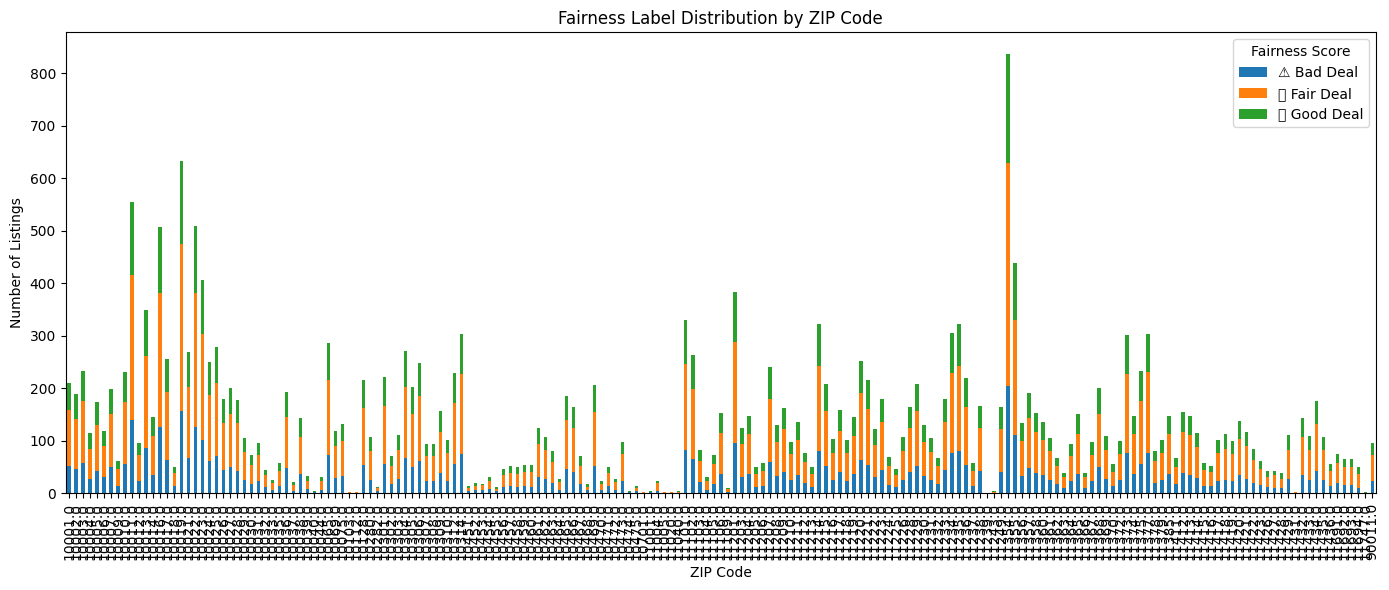

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count labels by ZIP code
zip_label_counts = df.groupby(["postal_code", "fairness_score"]).size().unstack().fillna(0)

# Plot stacked bar chart
zip_label_counts.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title("Fairness Label Distribution by ZIP Code")
plt.xlabel("ZIP Code")
plt.ylabel("Number of Listings")
plt.legend(title="Fairness Score")
plt.tight_layout()
plt.show()


In [ ]:
# Global baseline thresholds
global_q1 = df["modified_z"].quantile(0.25)
global_q3 = df["modified_z"].quantile(0.75)

def global_label(row):
    z = row["modified_z"]
    if z < global_q1:
        return "💎 Good Deal"
    elif z > global_q3:
        return "⚠️ Bad Deal"
    else:
        return "✅ Fair Deal"

df["baseline_score"] = df.apply(global_label, axis=1)

# Compare with ZIP-specific model
comparison = pd.crosstab(df["fairness_score"], df["baseline_score"], rownames=["ZIP-Specific"], colnames=["Global"])
print(comparison)


Global        ⚠️ Bad Deal  ✅ Fair Deal  💎 Good Deal
ZIP-Specific                                       
⚠️ Bad Deal          5783          479            0
✅ Fair Deal           525        11770          480
💎 Good Deal             0          421         5830


In [ ]:
def get_fairness_label(price, square_feet, zip_code, zip_cutoffs, fallback_lower=-0.4, fallback_upper=0.4):
    if square_feet == 0:
        return "Unknown"

    ppsf = price / square_feet

    if zip_code in zip_cutoffs:
        lower, upper, median, mad = zip_cutoffs[zip_code]
    else:
        median = df["price_per_sqft"].median()
        mad = robust.mad(df["price_per_sqft"])
        lower, upper = fallback_lower, fallback_upper

    if mad == 0 or pd.isna(mad):
        return "Unknown"

    z = 0.6745 * (ppsf - median) / mad

    if z < lower:
        return "💎 Good Deal"
    elif z > upper:
        return "⚠️ Bad Deal"
    else:
        return "✅ Fair Deal"


In [ ]:
# Example test listing
price = 800000
square_feet = 1000
zip_code = 10001

label = get_fairness_label(price, square_feet, zip_code, zip_cutoffs)
print(f"Fairness Label: {label}")


Fairness Label: 💎 Good Deal


In [ ]:
test_df = df.sample(5)[["price", "square_feet", "postal_code"]]

for _, row in test_df.iterrows():
    label = get_fairness_label(row["price"], row["square_feet"], row["postal_code"], zip_cutoffs)
    print(f"Price: {row['price']}, Sqft: {row['square_feet']}, ZIP: {row['postal_code']} → {label}")


Price: 418000.0, Sqft: 1100.0, ZIP: 11374.0 → 💎 Good Deal
Price: 4875000.0, Sqft: 2662.0, ZIP: 10025.0 → ✅ Fair Deal
Price: 1450000.0, Sqft: 1800.0, ZIP: 11358.0 → ✅ Fair Deal
Price: 598777.0, Sqft: 1041.0, ZIP: 11374.0 → 💎 Good Deal
Price: 1499000.0, Sqft: 841.0, ZIP: 10002.0 → ✅ Fair Deal


In [ ]:
cutoff_df = pd.DataFrame.from_dict(
    zip_cutoffs,
    orient='index',
    columns=['Lower Cutoff', 'Upper Cutoff', 'Median PPSF', 'MAD PPSF']
)
cutoff_df.index.name = 'ZIP Code'
cutoff_df = cutoff_df.reset_index()


In [ ]:
cutoff_df.to_csv("zip_cutoffs.csv", index=False)
